# Prediction visualization notebook

In [1]:
from dataLoader import DataLoader, compute_euclidean_distance, prepare_input_img
from block_matching_utils import *
from network import create_model
import os
import numpy as np
from custom_KFold import MyKFold
from PIL import Image
import pandas as pd
from tensorflow import keras
import logging
import skimage
import matplotlib.pyplot as plt
from utils import *
from global_tracking import *
from matplotlib.patches import Rectangle
# ============ DATA AND SAVING DIRS SETUP ========== #
data_dir = os.getenv('DATA_PATH')
test_dir = os.getenv('TEST_PATH')
exp_dir = os.getenv('EXP_PATH')


NameError: name 'exp_name' is not defined

In [2]:
np.random.seed(seed=42)
exp_name = 'exp_80_50_128_se60'
params_dict = {'dropout_rate': 0.5, 'n_epochs': 25,
               'h3': 0, 'embed_size': 128, 'width': 80, 'search_w': 60}

checkpoint_dir = os.path.join(exp_dir, exp_name)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
params_dict = get_default_params(params_dict)

In [ ]:
def plot_img_template(c1,c2,img, width=50, height=50):
    x = c1 - width/2
    y = c2 - height/2
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax.scatter(c1-1, c2-1, s=10)
    rect=Rectangle((x,y), width, height, fill=False)
    ax.add_patch(rect)
    plt.show()

## Restore trained model

In [3]:
model = create_model(params_dict['width']+1,
                     params_dict['h1'],
                     params_dict['h2'],
                     params_dict['h3'],
                     embed_size=params_dict['embed_size'],
                     drop_out_rate=params_dict['dropout_rate'],
                     use_batch_norm=params_dict['use_batchnorm'])
model.load_weights(os.path.join('/Users/melaniebernhardt/Downloads', 'model.h5'))

(?, 81, 81, 1)


### Get test folder

In [4]:
# ['ETH-04-1' 'MED-01-1' 'CIL-01' 'MED-02-2']
testfolder = 'ETH-04-1' 
resolution_df = pd.read_csv(os.path.join(data_dir, 'resolution.csv'),
                                         sep=',\s+',
                                         decimal='.')
res_x, res_y = resolution_df.loc[resolution_df['scan']
                == testfolder, ['res_x', 'res_y']].values[0]
testfolder = os.path.join(data_dir, 'ETH-04-1')

/Applications/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


### Predict on all features and save predictions

['ETH-04-1_1.txt', 'ETH-04-1_2.txt']


/Applications/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Applications/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


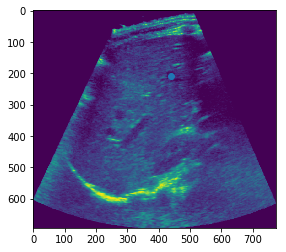

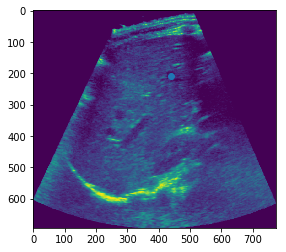

296.2629341125488 140.3616542816162


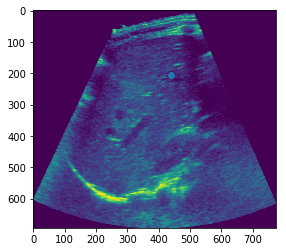

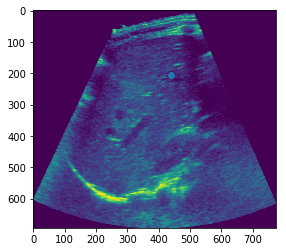

296.908683013916 139.74356002807616


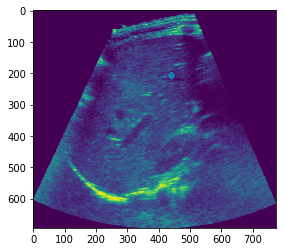

KeyboardInterrupt: 

In [5]:
predict_testfolder(testfolder, data_dir, res_x, res_y, model, params_dict)

## Visualize prediction for one feature

In [9]:
testfolder = 'ETH-04-1'
img_dir = os.path.join(data_dir, testfolder, 'Data')
annotation_dir = os.path.join(data_dir, testfolder, 'Annotation')
feat = 'ETH-04-1_1.txt'
direct = '/Volumes/MelanieDisk/CLUST_Runs/new_exp_80_20_128_60'
pred_feat1 = pd.read_csv(os.path.join('/Users/melaniebernhardt/Downloads', feat),
                                     sep=',',
                                     decimal='.', header=None, names = ['id', 'c1','c2'])
true_feat1 = pd.read_csv(os.path.join(annotation_dir, feat),
                                     sep='\s+',
                                     decimal='.', header=None, names = ['id', 'c1','c2'])

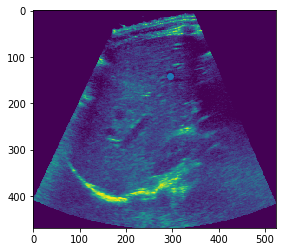

In [10]:
i =2
try:
    img = np.asarray(Image.open(os.path.join(img_dir, '{:04d}.png'.format(int(i)))))
except FileNotFoundError:
    img = np.asarray(Image.open(os.path.join(img_dir, '{:05d}.png'.format(int(i)))))
plt.imshow(img)
plt.scatter(pred_feat1.loc[pred_feat1.id==(i-1), 'c1'], pred_feat1.loc[pred_feat1.id==(i-1), 'c2'])
plt.show()

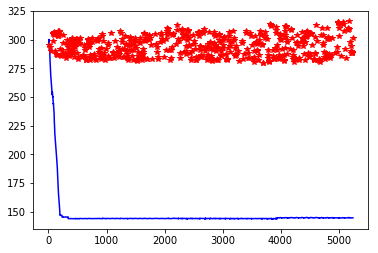

In [11]:
plt.plot(pred_feat1.id, pred_feat1.c1, 'b')
plt.plot(true_feat1.id, true_feat1.c1, 'r*')
plt.show()

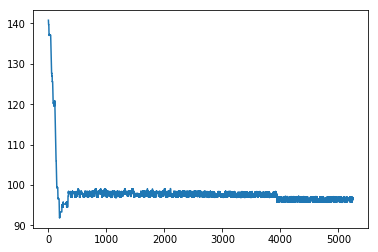

In [12]:
plt.plot(pred_feat1.id, pred_feat1.c2)
plt.show()

In [13]:
pred_feat1.head()

,id,c1,c2
0,1,295.320290,140.802490
1,2,295.910129,140.354465
2,3,296.630159,139.755312
3,4,297.266576,139.735485
4,5,298.044717,139.768588


In [14]:
true_feat1.head()

,id,c1,c2
0,1.0,295.32029,140.80249
1,31.0,293.24416,141.80331
2,38.0,290.08362,142.28764
3,70.0,298.50904,140.32738
4,79.0,305.06496,139.59487


In [15]:
list_id = true_feat1['id'].values
c_true = []
c_pred = []
for r,i in enumerate(list_id):
    c_true = np.append(c_true,true_feat1.loc[true_feat1['id']==i, ['c1', 'c2']].values)
    c_pred = np.append(c_pred, pred_feat1.loc[pred_feat1['id']==i-1, ['c1', 'c2']].values)

c_true = c_true.reshape(-1,2)
c_pred = c_pred.reshape(-1,2)
print(np.mean(np.sqrt((c_true[:,0]-c_pred[:,0])**2 + (c_true[:,1]-c_pred[:,1])**2)))

ValueError: operands could not be broadcast together with shapes (525,) (524,) 

In [16]:
from IPython import display
pred_feat1.head()

,id,c1,c2
0,1,295.320290,140.802490
1,2,295.910129,140.354465
2,3,296.630159,139.755312
3,4,297.266576,139.735485
4,5,298.044717,139.768588


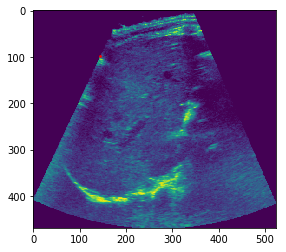

None

341
144.0409996032715 97.23785133361817


KeyboardInterrupt: 

In [17]:
import time
c1_list = pred_feat1.loc[:, 'c1'].values
c2_list = pred_feat1.loc[:,'c2'].values
print(c1_list[0:10])
for i in range(1,2000,20):
    
    try:
        img = np.asarray(Image.open(os.path.join(img_dir, '{:05d}.png'.format(i))))
    except FileNotFoundError:
        img = np.asarray(Image.open(os.path.join(img_dir, '{:04d}.png'.format(i))))
    plt.clf()
    plt.imshow(img)
    plt.scatter(c1_list[i-1], c2_list[i-1], 3, 'r')
    display.clear_output(wait=True)
    display.display(plt.show())
    print(i)
    print(c1_list[i-1],c2_list[i-1])
    time.sleep(1)

In [171]:
xax, yax = find_template_pixel(151, 86, width=80)
i = 61
try:
    img = np.asarray(Image.open(os.path.join(img_dir, '{:05d}.png'.format(i))))
except FileNotFoundError:
    img = np.asarray(Image.open(os.path.join(img_dir, '{:04d}.png'.format(i))))

template = img[np.ravel(yax), np.ravel(xax)].reshape(81,81)
plt.imshow(template)
plt.show()
print(np.histogram(template))
print(np.min(template))
print(np.percentile(template,50)==0)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/MelanieDisk/CLUST_Data/ETH-04-1/Data/0061.png'

In [170]:
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime, timedelta
c1_list = pred_feat1.c1[0:200].values
pred_feat1['dummy_date'] = pred_feat1.id.map(lambda s: datetime.strptime('Jun 1 2005', '%b %d %Y') + timedelta(seconds=s))
df = pred_feat1.loc[0:200,].copy()
df.index = df.dummy_date
history = df.c1.values
for t in range(100):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)[0]
    history = np.append(history, output)
    c1_list = np.append(c1_list,model_fit.forecast(steps=1)[0])


/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


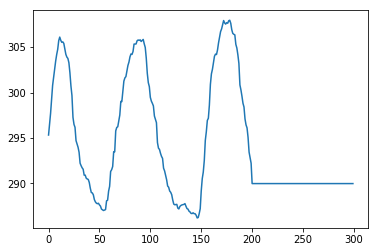

In [169]:
plt.plot(c1_list)
plt.show()

In [165]:
model_fit.forecast(steps=1)

(array([289.97421749]),
 array([0.50580414]),
 array([[288.9828596 , 290.96557538]]))

In [137]:
c1_list[-1]

-0.022035423988863278

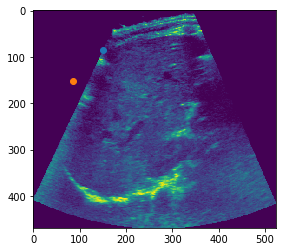

In [195]:
plt.imshow(img)
plt.scatter(151, 86)
plt.scatter(86, 151)
plt.show()

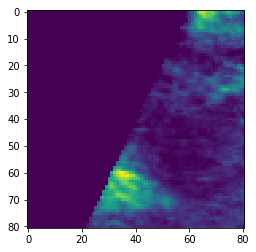

(array([4780,  894,  317,  166,  146,  110,   74,   52,   13,    9]), array([  0. ,  13.7,  27.4,  41.1,  54.8,  68.5,  82.2,  95.9, 109.6,
       123.3, 137. ]))
0
True


In [173]:
template = img[np.ravel(yax), np.ravel(xax)].reshape(81,81)
plt.imshow(template)
plt.show()
print(np.histogram(template))
print(np.min(template))
print(np.percentile(template,50)==0)

In [181]:
a, b = np.nonzero(img) # 151, 86

In [189]:
a2, b2 = a[np.where(a==86)], b[np.where(a==86)]

In [199]:
img[86, 150]

2

In [200]:
b2[0]

150

In [1]:
d = DataLoader()

NameError: name 'DataLoader' is not defined

In [7]:
from dataLoader import DataLoader, compute_euclidean_distance, prepare_input_img
from block_matching_utils import *
from network import create_model
import os
import numpy as np
from custom_KFold import MyKFold
from PIL import Image
import pandas as pd
from tensorflow import keras
import logging
import skimage
import matplotlib.pyplot as plt
from utils import *
from global_tracking import *
from matplotlib.patches import Rectangle
# ============ DATA AND SAVING DIRS SETUP ========== #
data_dir = os.getenv('DATA_PATH')
test_dir = os.getenv('TEST_PATH')
exp_dir = os.getenv('EXP_PATH')


kf = MyKFold(data_dir, n_splits=5)
fold_iterator = kf.getFolderIterator()
traindirs, testdirs = next(fold_iterator) 
training_generator = DataLoader(
            data_dir, traindirs, 32,
            width_template=80)

(24,)
Number folders per fold: 4
24
['MED-05-1' 'CIL-01' 'ICR-01' 'CIL-02']
['ICR-02' 'ETH-04-1' 'ETH-01-1' 'ETH-02-2' 'ETH-01-2' 'ICR-03' 'ETH-02-1'
 'MED-01-1' 'MED-04-1' 'ETH-05-2' 'MED-02-2' 'MED-02-3' 'ETH-04-2'
 'ETH-03-2' 'MED-03-2' 'ICR-04' 'MED-02-1' 'ETH-05-1' 'ETH-03-1'
 'MED-03-1']


/Users/melaniebernhardt/Desktop/USMotionTracking/custom_KFold.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  decimal='.')
/Users/melaniebernhardt/Desktop/USMotionTracking/dataLoader.py:98: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  decimal='.')


(15287,)
(15287,)
15287


In [8]:
[batch_imgs, batch_imgs_init, batch_centers], batch_labels = training_generator.__getitem__(0)

/Applications/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Applications/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [9]:
batch_imgs.shape

(32, 81, 81)

In [10]:
batch_centers[0]

array([414.12479724, 217.93636482])

In [11]:
batch_labels[0]

array([423.55864375, 215.8888305 ])

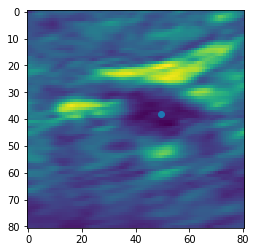

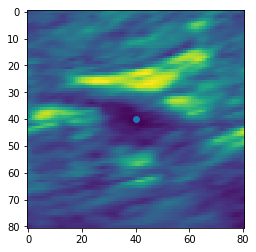

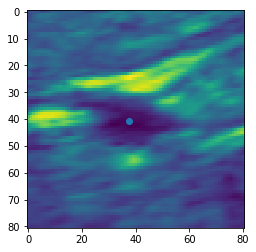

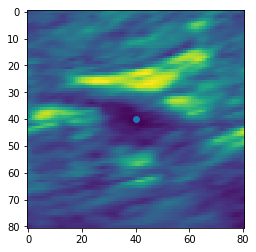

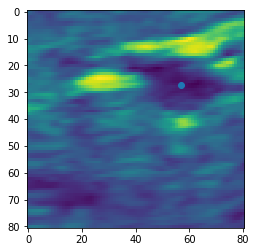

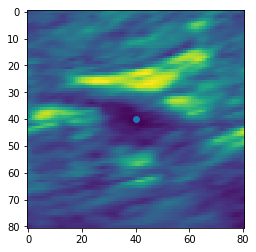

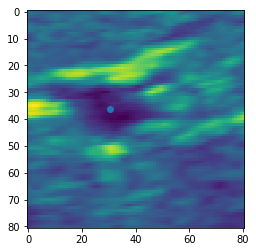

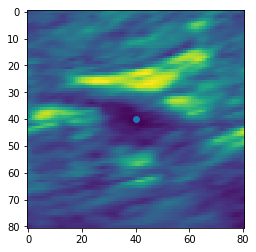

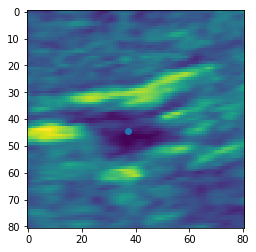

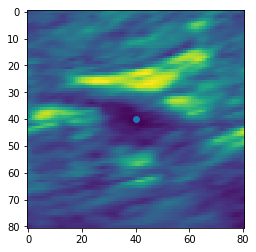

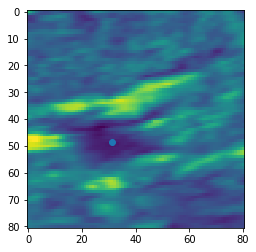

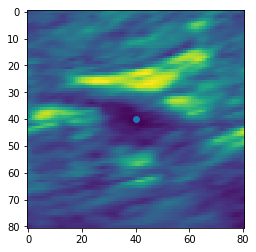

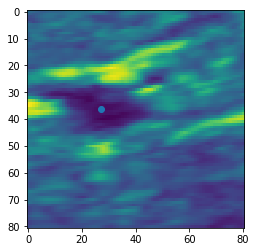

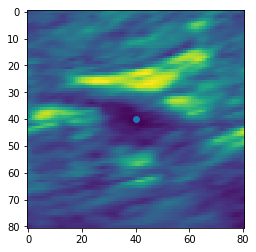

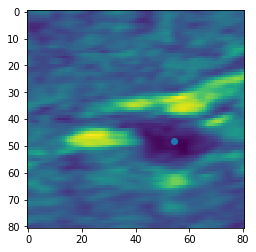

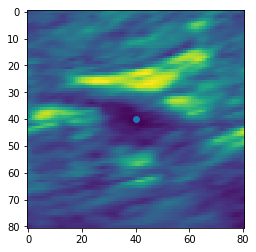

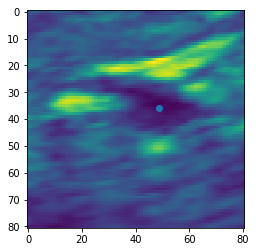

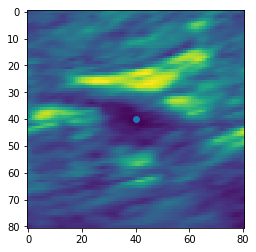

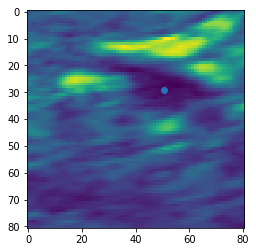

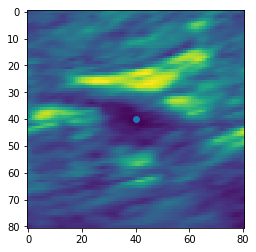

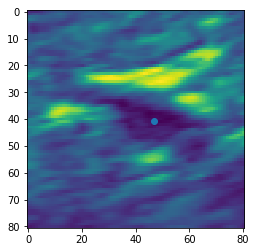

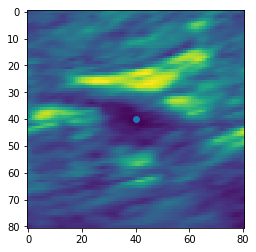

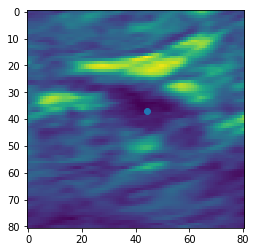

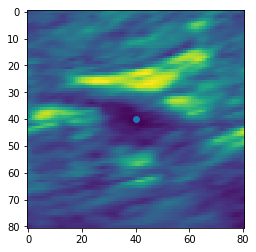

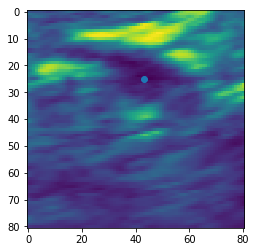

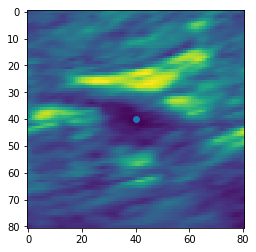

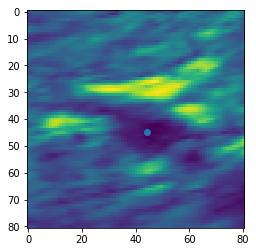

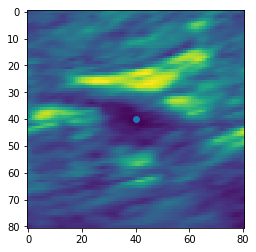

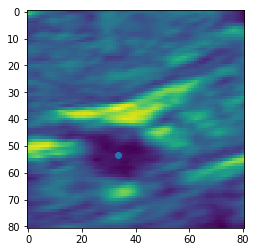

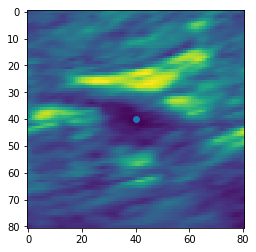

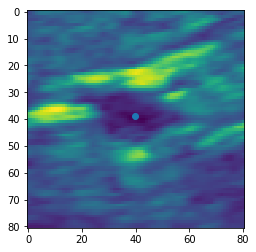

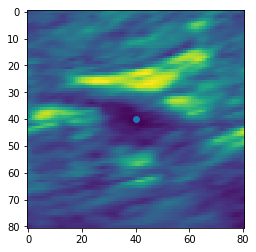

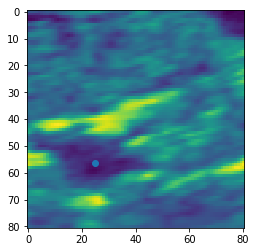

In [ ]:
for i in range(0,32):
    plt.imshow(batch_imgs[i])
    plt.scatter(batch_labels[i, 0]-batch_centers[i,0]+40, batch_labels[i, 1]-batch_centers[i,1]+40)
    plt.show()
    plt.imshow(batch_imgs_init[i])
    plt.scatter(40,40)
    plt.show()

# Trial with temporal prediction

In [8]:
testfolder = 'ETH-04-1'
img_dir = os.path.join(data_dir, testfolder, 'Data')
annotation_dir = os.path.join(data_dir, testfolder, 'Annotation')
feat = 'ETH-04-1_1.txt'
direct = '/Volumes/MelanieDisk/CLUST_Runs/new_exp_80_20_128_60'
pred_feat1 = pd.read_csv(os.path.join('/Users/melaniebernhardt/Downloads', feat),
                                     sep=',',
                                     decimal='.', header=None, names = ['id', 'c1','c2'])
true_feat1 = pd.read_csv(os.path.join(annotation_dir, feat),
                                     sep='\s+',
                                     decimal='.', header=None, names = ['id', 'c1','c2'])

In [ ]:
n = len(df.c1.values)
X = df.c1.values
X1 = df.c1.values[1:n]
X2 = df.c1.values[2:n]
X3 = df.c1.values[3:n]
X4 = df.c1.values[4:n]
X5 = df.c1.values[5:n]
X6 = df.c1.values[6:n]
X7 = df.c1.values[7:n]
X8 = df.c1.values[8:n]
X9 = df.c1.values[9:n]
X10 = df.c1.values[10:n]
l = len(X10)
fullX = np.vstack([X[0:l], X1[0:l], X2[0:l], X3[0:l], X4[0:l], X5[0:l], X6[0:l], X7[0:l], X8[0:l], X9[0:l]])
y = X10
print(fullX[0])

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
est = RidgeCV()
scores = cross_val_score(est, fullX, y, cv=5)